# Các thư viện cần thiết

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import rand, col, regexp_replace, when, trim, lit, coalesce
from pyspark.sql import types as T
# Spark ML pipeline
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    VectorAssembler,
    StringIndexer,
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.sql.functions import rand
# LightGBM cho Spark (SynapseML)
from synapse.ml.lightgbm import LightGBMRegressor
# Model tuning & evaluation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import ChiSquareTest
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand, when, lit
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import numpy as np

import os
import time

StatementMeta(, ea7889d9-9451-4323-97bc-cd729f7485e1, 16, Finished, Available, Finished)

In [ ]:
# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("E-commerce-analysis") \
    .getOrCreate()

StatementMeta(, ea7889d9-9451-4323-97bc-cd729f7485e1, 4, Finished, Available, Finished)

In [ ]:
delivered_data = spark.read.csv("Files/ecommerce_data_generated/clean_data.csv", header=True, inferSchema=True)
delivered_data.show(5)

StatementMeta(, ea7889d9-9451-4323-97bc-cd729f7485e1, 5, Finished, Available, Finished)

+---+-------------+---------------------+-------------+-----------+-------------+-----------+----------+------------+------------+--------------+------------------+-----------------+
|_c0|freight_value|product_category_name|customer_city|seller_city|delivery_time|distance_km|route_type|purchase_dow|purchase_dom|purchase_month|      product_size|product_weight_kg|
+---+-------------+---------------------+-------------+-----------+-------------+-----------+----------+------------+------------+--------------+------------------+-----------------+
|  0|      1043000| may_anh_may_quay_...|     Bac Lieu| Binh Thuan|         2.38|     436.32| Liên tỉnh|           1|          11|             4|25.255999999999997|            0.574|
|  1|       179000|        thoi_trang_nu|     Bac Lieu| Binh Thuan|         2.38|     436.32| Liên tỉnh|           1|          11|             4|              2.85|             3.51|
|  2|        34000|  sach_van_phong_pham|     Bac Lieu| Binh Thuan|         2.38|    

In [ ]:
def stats(df, col_list=None):
    if col_list is None:
        col_list = [f.name for f in df.schema.fields if isinstance(f.dataType, T.NumericType)]

    all_stats = []

    # Lặp qua từng cột để tính toán
    for col_name in col_list:
        # Aggregation cơ bản + Percentile
        agg_exprs = [
            F.count(col_name).alias('Count'),
            F.min(col_name).alias('Min'),
            F.max(col_name).alias('Max'),
            F.mean(col_name).alias('Average'),
            F.variance(col_name).alias('Var'),
            F.stddev(col_name).alias('Stdev'),
            F.percentile_approx(col_name, 0.25).alias('Q1'),
            F.percentile_approx(col_name, 0.50).alias('Median'),
            F.percentile_approx(col_name, 0.75).alias('Q3')
        ]
        # Lấy kết quả Aggregation
        res = df.select(agg_exprs).collect()[0]
        # Tính Mode
        mode_row = df.groupBy(col_name).count().orderBy(F.col("count").desc()).first()
        mode_val = mode_row[col_name] if mode_row else None
        # Xử lý các giá trị (IQR)
        q1 = res['Q1']
        q3 = res['Q3']
        iqr = (q3 - q1) if (q3 is not None and q1 is not None) else None

        # Tạo Series thống kê cho cột hiện tại
        stats_series = pd.Series({
            'Count': res['Count'],
            'Min': res['Min'],
            'Max': res['Max'],
            'Average': res['Average'],
            'Median': res['Median'],
            'Mode': mode_val,
            'Q1': q1,
            'Q2': res['Median'],
            'Q3': q3,
            'IQR': iqr,
            'Var': res['Var'],
            'Stdev': res['Stdev']
        }, name=col_name)
        all_stats.append(stats_series)

    final_stats_df = pd.concat(all_stats, axis=1)
    return final_stats_df.reset_index()

StatementMeta(, ea7889d9-9451-4323-97bc-cd729f7485e1, 6, Finished, Available, Finished)

In [ ]:
print("Bảng thống kê các dữ liệu số:")
display(stats(delivered_data))

StatementMeta(, ea7889d9-9451-4323-97bc-cd729f7485e1, 7, Finished, Available, Finished)

Bảng thống kê các dữ liệu số:


SynapseWidget(Synapse.DataFrame, 101eb37a-5453-4073-8706-0dbab636bac1)

In [ ]:
def get_categorical_stats(df):
    # Lấy danh sách các cột phi số
    cat_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, T.StringType)]
    stats_data = []
    for col_name in cat_cols:
        # Tính Count (số dòng không null) và Unique (số giá trị duy nhất)
        basic_metrics = df.select(
            F.count(col_name).alias("count"),
            F.countDistinct(col_name).alias("unique")
        ).collect()[0]

        count_val = basic_metrics["count"]
        unique_val = basic_metrics["unique"]

        # Tìm Top (Mode) và Freq
        # GroupBy -> Count -> Order Desc -> Lấy dòng đầu tiên
        if count_val > 0:
            top_row = df.groupBy(col_name) \
                        .count() \
                        .orderBy(F.col("count").desc()) \
                        .first()

            top_val = top_row[col_name]
            freq_val = top_row["count"]
        else:
            top_val = None
            freq_val = 0

        # Tính % Top
        top_percent = (freq_val / count_val * 100) if count_val > 0 else 0.0

        # Lưu kết quả
        stats_data.append({
            "index": col_name,
            "count": count_val,
            "unique": unique_val,
            "top": top_val,
            "freq": freq_val,
            "top_percent": top_percent
        })

    # Chuyển list dictionary thành Pandas DataFrame để hiển thị đẹp
    cat_summary_df = pd.DataFrame(stats_data)

    # Sắp xếp theo cột 'unique' (độ đa dạng dữ liệu) như yêu cầu gốc
    if not cat_summary_df.empty:
        cat_summary_df = cat_summary_df.sort_values(by='unique').reset_index(drop=True)

    return cat_summary_df

print("Bảng thống kê các trường dữ liệu phi số của data:")
cat_summary_spark = get_categorical_stats(delivered_data)
display(cat_summary_spark)

StatementMeta(, ea7889d9-9451-4323-97bc-cd729f7485e1, 8, Finished, Available, Finished)

Bảng thống kê các trường dữ liệu phi số của data:


SynapseWidget(Synapse.DataFrame, 6e4e63dc-0780-4674-95cf-3e138e3135a3)

# 4. Xây dựng mô hình

In [ ]:
cat_cols = ["product_category_name", "customer_city", "seller_city", "route_type"]
num_cols = ["freight_value", "distance_km", "purchase_dow", "purchase_dom",
            "purchase_month", "product_size", "product_weight_kg"]

stages = []

# 1. Xử lý biến phân loại
for col_name in cat_cols:
    # StringIndexer: Chữ => Số
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_idx", handleInvalid="keep")
    # OneHotEncoder: Số => Vector
    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[f"{col_name}_vec"])
    stages += [indexer, encoder]

# 2. Xử lý biến số
num_assembler = VectorAssembler(inputCols=num_cols, outputCol="num_features_raw")
# Chuẩn hóa StandardScaling
scaler = StandardScaler(inputCol="num_features_raw", outputCol="num_features_scaled",
                        withStd=True, withMean=True)
stages += [num_assembler, scaler]

# 3. Tổng hợp các features
input_cols = [f"{c}_vec" for c in cat_cols] + ["num_features_scaled"]
final_assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
stages.append(final_assembler)

# 4. Khởi tạo Model Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="delivery_time")
stages.append(lr)

# Tạo Pipeline tổng thể (chưa fit)
pipeline = Pipeline(stages=stages)

StatementMeta(, ea7889d9-9451-4323-97bc-cd729f7485e1, 9, Finished, Available, Finished)

In [ ]:
random_states = [42, 10, 2024, 99, 123, 7, 88, 555, 1000, 1]

results = []

print(f"{'Run':<3} | {'Seed':<5} | {'Time(s)':<7} | {'Train RMSE':<10} | {'Test RMSE':<10} | {'Test R2':<8} | {'Gap (Overfit)':<10}")
print("-" * 80)

# Evaluator
evaluator = RegressionEvaluator(labelCol="delivery_time", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="delivery_time", predictionCol="prediction", metricName="r2")

trained_model = None # Biến để lưu model cuối cùng cho phần feature importance

for i, seed in enumerate(random_states):
    start_time = time.time()

    # 1. Chia dữ liệu Train/Test (80/20) theo seed
    train_data, test_data = delivered_data.randomSplit([0.8, 0.2], seed=seed)

    # 2. Huấn luyện Pipeline
    model = pipeline.fit(train_data)
    trained_model = model # Lưu lại model

    # 3. Đánh giá trên tập TRAIN
    train_pred = model.transform(train_data)
    train_rmse = evaluator.evaluate(train_pred)

    # 4. Đánh giá trên tập TEST
    test_pred = model.transform(test_data)
    test_rmse = evaluator.evaluate(test_pred)
    test_r2 = evaluator_r2.evaluate(test_pred)

    end_time = time.time()
    duration = end_time - start_time

    # Tính độ lệch (Gap) giữa Train và Test -> Gap càng lớn càng Overfit
    gap = test_rmse - train_rmse

    results.append({
        'run': i+1,
        'seed': seed,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'time': duration
    })

    print(f"{i+1:<3} | {seed:<5} | {duration:.4f}  | {train_rmse:.4f}     | {test_rmse:.4f}     | {test_r2:.4f}   | {gap:.4f}")

print("-" * 80)

StatementMeta(, ea7889d9-9451-4323-97bc-cd729f7485e1, 10, Finished, Available, Finished)

Run | Seed  | Time(s) | Train RMSE | Test RMSE  | Test R2  | Gap (Overfit)
--------------------------------------------------------------------------------


1   | 42    | 179.8955  | 0.8115     | 0.8107     | 0.7860   | -0.0008


2   | 10    | 123.6868  | 0.8113     | 0.8115     | 0.7858   | 0.0002


3   | 2024  | 114.7591  | 0.8113     | 0.8113     | 0.7850   | 0.0000


4   | 99    | 110.2503  | 0.8110     | 0.8126     | 0.7854   | 0.0015


5   | 123   | 115.1481  | 0.8116     | 0.8104     | 0.7854   | -0.0011


6   | 7     | 137.1918  | 0.8116     | 0.8103     | 0.7856   | -0.0013


7   | 88    | 98.0973  | 0.8112     | 0.8120     | 0.7857   | 0.0008


8   | 555   | 83.7478  | 0.8113     | 0.8115     | 0.7858   | 0.0002


9   | 1000  | 81.4363  | 0.8114     | 0.8112     | 0.7863   | -0.0002


10  | 1     | 81.2949  | 0.8117     | 0.8099     | 0.7867   | -0.0018
--------------------------------------------------------------------------------


In [ ]:
# Chuyển kết quả sang Pandas để tính toán thống kê
res_df = pd.DataFrame(results)

avg_test_rmse = res_df['test_rmse'].mean()
std_test_rmse = res_df['test_rmse'].std()
avg_gap = (res_df['test_rmse'] - res_df['train_rmse']).mean()

print("\nTổng hợp kết quả đánh giá mô hình")
print(f"1. Độ ổn định (Stability):")
print(f"   - RMSE trung bình trên tập Test: {avg_test_rmse:.4f}")
print(f"   - Độ lệch chuẩn (Std) của RMSE : {std_test_rmse:.4f}")

print(f"\n3. Thời gian huấn luyện trung bình: {res_df['time'].mean():.4f} giây")

StatementMeta(, ea7889d9-9451-4323-97bc-cd729f7485e1, 11, Finished, Available, Finished)


Tổng hợp kết quả đánh giá mô hình
1. Độ ổn định (Stability):
   - RMSE trung bình trên tập Test: 0.8111
   - Độ lệch chuẩn (Std) của RMSE : 0.0008

3. Thời gian huấn luyện trung bình: 112.5508 giây


StatementMeta(, ea7889d9-9451-4323-97bc-cd729f7485e1, 20, Finished, Available, Finished)

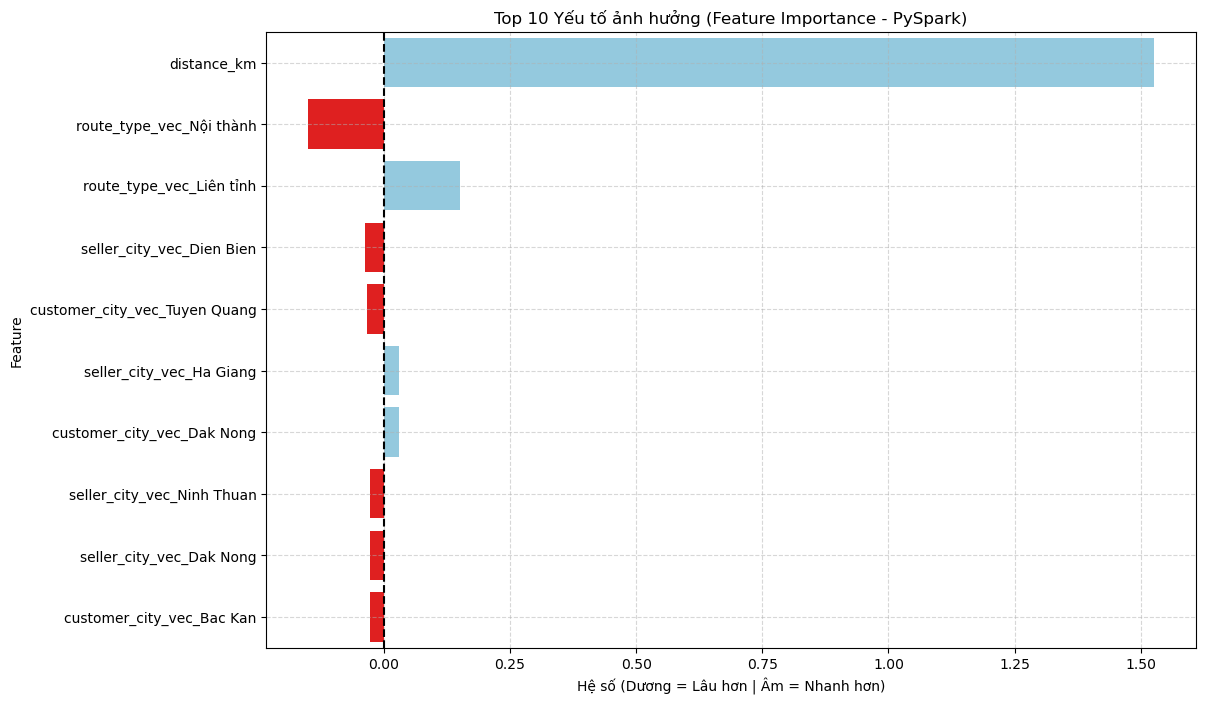

Hệ số chặn (Intercept): 4.4827
--------------------------------------------------
Bảng chi tiết 10 yếu tố quan trọng nhất:
                           Feature  Coefficient
140                    distance_km     1.526126
138       route_type_vec_Nội thành    -0.149749
137       route_type_vec_Liên tỉnh     0.149749
126      seller_city_vec_Dien Bien    -0.037163
65   customer_city_vec_Tuyen Quang    -0.033678
130       seller_city_vec_Ha Giang     0.030733
64      customer_city_vec_Dak Nong     0.030038
108     seller_city_vec_Ninh Thuan    -0.027881
129       seller_city_vec_Dak Nong    -0.027837
66       customer_city_vec_Bac Kan    -0.027423


In [ ]:
# 1. Hàm trích xuất tên feature (Giữ nguyên)
def get_feature_names_manual(df, features_col="features"):
    try:
        field = df.schema[features_col]
        metadata = field.metadata
        if "ml_attr" not in metadata: return None
        ml_attr = metadata["ml_attr"]
        attrs = ml_attr.get("attrs", {})
        features_list = []
        for attr_type in ["numeric", "binary", "nominal"]:
            if attr_type in attrs:
                for attr in attrs[attr_type]:
                    features_list.append((attr["idx"], attr.get("name", f"feat_{attr['idx']}")))
        features_list.sort(key=lambda x: x[0])
        return [x[1] for x in features_list]
    except Exception as e:
        print(f"Không lấy được metadata: {e}")
        return None

# 2. Lấy Model và Hệ số
if 'trained_model' not in locals():
    print("Đang huấn luyện lại model để lấy metadata...")
    trained_model = pipeline.fit(train_data)

lr_model = trained_model.stages[-1]
coefficients = lr_model.coefficients.toArray()

# 3. Lấy tên Features từ Metadata
predictions = trained_model.transform(test_data)
feature_names = get_feature_names_manual(predictions)

# Fallback nếu lỗi
if not feature_names or len(feature_names) != len(coefficients):
    print("Cảnh báo: Không map được tên cột. Dùng tên mặc định.")
    feature_names = [f"Feature_{i}" for i in range(len(coefficients))]

# ==============================================================================
# SỬA LỖI TẠI ĐÂY: TẠO DATAFRAME TRƯỚC RỒI MỚI MAPPING
# ==============================================================================

# 4. Tạo DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 5. Khai báo danh sách tên gốc (Đảm bảo đúng thứ tự num_cols trong Pipeline)
num_cols = [
    "freight_value",    # 0
    "distance_km",      # 1
    "purchase_dow",     # 2
    "purchase_dom",     # 3
    "purchase_month",   # 4
    "product_size",     # 5
    "product_weight_kg" # 6
]

# 6. Tạo Dictionary Mapping và Thay thế
mapping_dict = {}
for i, col_name in enumerate(num_cols):
    key = f"num_features_scaled_{i}"
    mapping_dict[key] = col_name

# Áp dụng thay thế
coef_df['Feature'] = coef_df['Feature'].replace(mapping_dict)

# 7. Sắp xếp và lấy Top 10
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
top_10 = coef_df.head(10)

# 8. Vẽ biểu đồ
plt.figure(figsize=(12, 8))
# Tùy chỉnh màu: Đỏ (Âm/Giảm) - Xanh (Dương/Tăng)
colors = ['red' if x < 0 else 'skyblue' for x in top_10['Coefficient']]

sns.barplot(x='Coefficient', y='Feature', data=top_10, palette=colors)

plt.title('Top 10 Yếu tố ảnh hưởng (Feature Importance - PySpark)')
plt.xlabel('Hệ số (Dương = Lâu hơn | Âm = Nhanh hơn)')
plt.axvline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 9. In kết quả
print(f"Hệ số chặn (Intercept): {lr_model.intercept:.4f}")
print("-" * 50)
print("Bảng chi tiết 10 yếu tố quan trọng nhất:")
print(top_10[['Feature', 'Coefficient']])